In [30]:
def auc_xgb(preds, dtrain):
    labels = dtrain.get_label()
    
    try: 
        auc_score = roc_auc_score(labels, preds)
    except:
        auc_score = 0
    
    return 'AUC', auc_score

# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [31]:
#clf = RandomForestClassifier(n_jobs=4, random_state=0, class_weight={0:1,1:5}, n_estimators=100)
#clf.fit(X_train,y_train)
#Stratified KFold
kfold = 10
skf = StratifiedKFold(n_splits=kfold)

X = X_train #.loc[:, predictors.columns != 'premium']
y = y_train
#test_id = testdf.id.values
#test = testdf.loc[:, testdf.columns != 'id']
#test = test #.loc[:, test.columns != 'premium']

#sub = pd.DataFrame()
#sub['id'] = test_id
#sub['target'] = np.zeros_like(test_id)

#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
    #'min_child_weight': 1,
    'objective': 'binary:logistic',
    'max_depth': 4,
    #'max_delta_step': .75,
    #'colsample_bytree': .9,
    #'subsample': .8,
    'eta': 0.001,
    #'gamma': 0.4,
    'n_estimators':250,
    'num_parallel_tree' : 1, 
    'tree_method' : 'exact',
    'lambda':1 #default 1
    }

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    # Convert our data into XGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(X_test.values)
    d_test.feature_names = d_train.feature_names
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 1,600 rounds (with early stopping after 70)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    #mdl = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=75, feval=auc_xgb, maximize=True, verbose_eval=False)
    mdl = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=250,
                    feval=gini_xgb, maximize = True, verbose_eval=False)
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    #sub['target'] += p_test/kfold

clf = mdl

[Fold 1/10]
[Fold 1/10 Prediciton:]
[Fold 2/10]
[Fold 2/10 Prediciton:]
[Fold 3/10]
[Fold 3/10 Prediciton:]
[Fold 4/10]
[Fold 4/10 Prediciton:]
[Fold 5/10]
[Fold 5/10 Prediciton:]
[Fold 6/10]
[Fold 6/10 Prediciton:]
[Fold 7/10]
[Fold 7/10 Prediciton:]
[Fold 8/10]
[Fold 8/10 Prediciton:]
[Fold 9/10]
[Fold 9/10 Prediciton:]
[Fold 10/10]
[Fold 10/10 Prediciton:]


In [32]:
predicted = clf.predict(xgb.DMatrix(X_train))
predicted = pd.DataFrame(predicted)
thresh = 0.5050000000000003
predicted = predicted > thresh

accuracy_score(predicted, y_train)

0.9615384615384616

In [33]:
accuracy_score(predicted, y_train)

0.9615384615384616

In [34]:
roc_auc_score(predicted, y_train)

0.959736740224545

In [35]:
recall_score(predicted, y_train)

0.9512195121951219

In [36]:
precision_score(predicted, y_train)

0.9512195121951219

In [37]:
testpredictorsDMA = xgb.DMatrix(X_test.values)
testpredictorsDMA.feature_names = d_train.feature_names
testpredictedProbabilites = clf.predict(testpredictorsDMA)
testPredicted = testpredictedProbabilites > thresh

In [38]:
accuracy_score(testPredicted, y_test)

0.8461538461538461

In [39]:
roc_auc_score(testPredicted, y_test)

0.8368983957219251

In [40]:
recall_score(testPredicted, y_test)

0.7647058823529411

In [41]:
precision_score(testPredicted, y_test)

0.8666666666666667

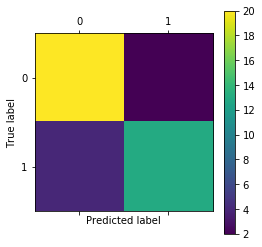

In [42]:
y_true = y_test
y_pred = testPredicted
cm = confusion_matrix(y_pred, y_true)
#labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


#x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.xticks(x, labels)
#plt.yticks(x, labels)
plt.show()

In [43]:
cm

array([[20,  2],
       [ 4, 13]], dtype=int64)

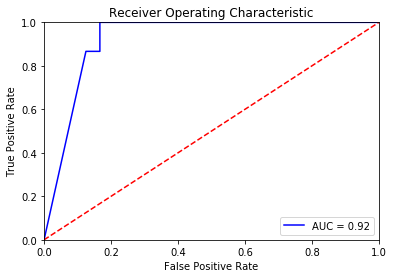

In [44]:
from sklearn import metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict(testpredictorsDMA)
preds = probs
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from matplotlib import pyplot
#plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(8, 7))
plot_importance(clf, ax, max_num_features = 10)
pyplot.show()